# Text and images: Getting Started with Multimodal on Sagemaker
Information in the real world usually comes as different sensory input/output channels, like: images that can be associated with text explanations; or text that contains images to more clearly express the main idea of the article. 
*Multimodal learning* is a good model to represent the joint representations of different modalities.
In this talk  we would provide a gentle introduction to Multimodal learning and would train and deploy a multimodal predictor based on natural language text, images and tabular data using SageMaker and AutoGloun.

We will train a model that takes pet NLP descriptions, images and tabular features to predict how fast (category) they will get adopted.


## Step 1: Install libraries and prepare environment 
! Important: this workshop was tested on ml.g4dn.8xlarge, 200 GB (!!!), conda_mxnet_p37 kernel 

Because 'llvmlite' is a distutils installed project, pip is not able to remove it. 
Let's remove it manually.

In [ ]:
%%time 
!find /home/ec2-user/anaconda3 -type f -name '*llvmlite*.egg-info' -delete

Next, we'll upgrade pip amd install autogluon lib.

In [ ]:
%pip install -U pip
%pip install -U setuptools wheel
%pip install -U mxnet<2.0.0
%pip install autogluon --ignore-installed
%pip install -U sagemaker

To ensure we can run local mode, increase the conda memory to 95%.

In [4]:
!cp -f image.py /home/ec2-user/anaconda3/envs/mxnet_p37/lib/python3.7/site-packages/sagemaker/local/image.py

In [ ]:
# only run the below cells when you are using sagemaker notebook instances
!bash ./prepare-docker.sh

In [ ]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/local_mode_setup.sh
!/bin/bash ./local_mode_setup.sh

Restart the kernel

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

## Step 2: Download and explore data

In [63]:
import sagemaker
import os
import subprocess
from sagemaker.mxnet import MXNet
from autogluon.core.utils.loaders import load_zip
from sagemaker.s3 import S3Uploader, s3_path_join

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/DEMO-autogluon-text-image-multimodel"
region = sagemaker_session.boto_region_name
account_id = sagemaker_session.account_id()
role = sagemaker.get_execution_role()

In [64]:
download_dir = './ag_automm_tutorial'
zip_file = 'https://automl-mm-bench.s3.amazonaws.com/petfinder_for_tutorial.zip'

In [ ]:
%%time
load_zip.unzip(zip_file, unzip_dir=download_dir)

Explore the data

In [65]:
import pandas as pd
dataset_path = download_dir + '/petfinder_for_tutorial'
train_data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
test_data = pd.read_csv(f'{dataset_path}/test.csv', index_col=0)
label_col = 'AdoptionSpeed'

In [66]:
image_col = 'Images'
train_data[image_col] = train_data[image_col].apply(lambda ele: ele.split(';')[0]) # Use the first image for a quick tutorial
test_data[image_col] = test_data[image_col].apply(lambda ele: ele.split(';')[0])


def path_expander(path, base_folder):
    path_l = path.split(';')
    return ';'.join([os.path.abspath(os.path.join(base_folder, path)) for path in path_l])

train_data[image_col] = train_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))
test_data[image_col] = test_data[image_col].apply(lambda ele: path_expander(ele, base_folder=dataset_path))

train_data[image_col].iloc[0]

'/home/ec2-user/SageMaker/sagemaker-multimodal-workshop/ag_automm_tutorial/petfinder_for_tutorial/images/7d7a39d71-1.jpg'

In [ ]:
train_data['AdoptionSpeed'].hist()

In [ ]:
train_data.hist(figsize=(20,20))

In [69]:
example_row = train_data.iloc[0]

example_row

Type                                                             2
Name                                                 Yumi Hamasaki
Age                                                              4
Breed1                                                         292
Breed2                                                         265
Gender                                                           2
Color1                                                           1
Color2                                                           5
Color3                                                           7
MaturitySize                                                     2
FurLength                                                        2
Vaccinated                                                       1
Dewormed                                                         3
Sterilized                                                       2
Health                                                        

In [ ]:
example_row['Description']


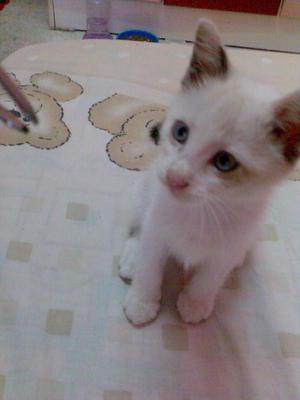

In [70]:
example_image = example_row[image_col]

from IPython.display import Image, display
pil_img = Image(filename=example_image)
display(pil_img)

Upload to s3

In [ ]:
s3_data_path = s3_path_join("s3://", bucket, f"{prefix}/data")
dataset_path = download_dir + '/petfinder_for_tutorial'
print(f"Uploading data to {s3_data_path}")
data_uri = S3Uploader.upload(dataset_path, s3_data_path)

## Train the model

In [ ]:
instance_type = "local"

try:
    if subprocess.call("nvidia-smi") == 0:
        ## Set type to GPU if one is present
        instance_type = "local_gpu"
except:
    pass

print("Instance type = " + instance_type)

In [13]:
from sagemaker import image_uris

In [14]:
image_uri = image_uris.retrieve(
            "autogluon",
            region=region,
            version="0.5",
            py_version="py38",
            image_scope="training",
            instance_type="local_gpu",
        )

In [15]:
from sagemaker.estimator import Estimator

In [16]:
model_artifacts_location = f"s3://{bucket}/{prefix}/artifacts"
mnist_estimator = Estimator(
    entry_point="train.py",
    role=role,
    output_path=model_artifacts_location,
    instance_count=1,
    instance_type="local_gpu",
    image_uri=image_uri,
    volume_size=200
)

In [ ]:
mnist_estimator.fit({"training": data_uri})

## Batch Inference

In [ ]:
from sagemaker.processing import FrameworkProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.utils import name_from_base
from sagemaker.sklearn.estimator import SKLearn

In [ ]:
est_cls = SKLearn
framework_version_str="0.23-1"

base_job_name = 'multimodel-inference'
mm_processor = FrameworkProcessor(
    estimator_cls=est_cls,
    image_uri=image_uri,
    framework_version=framework_version_str,
    role=role,
    instance_type="local",
    instance_count=1, 
    base_job_name=base_job_name,
)
processing_job_name = name_from_base(base_job_name)

In [ ]:
mm_processor.run(
    code='processing_script.py',
    source_dir='processing_src',
    arguments = [
                 '--base_dir', '/opt/ml/processing',
                ],
    inputs=[
        ProcessingInput(
            source=f"{data_uri}/test.csv",
            destination="/opt/ml/processing/input/test",
            s3_data_distribution_type="FullyReplicated",
        ),
        ProcessingInput(
            source=f"{data_uri}/images",
            destination="/opt/ml/processing/input/test/images",
            s3_data_distribution_type="FullyReplicated",
        ),
        ProcessingInput(
            source=model_data,
            destination="/opt/ml/processing/input/model",
            s3_data_distribution_type="FullyReplicated",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="inference_result", source="/opt/ml/processing/output/inference_result", destination="inference_result")
    ],
    job_name=processing_job_name,

)

In [ ]:
results_s3_path = f"s3://{bucket}/{processing_job_name}/output/inference_result"
S3Downloader.download(s3_uri=results_s3_path, local_path='./',sagemaker_session=sagemaker_session)

In [ ]:
# generate classification report
from sklearn import metrics
y_pred_class=pd.read_json('result.json',typ='series')
y_test = test_data['AdoptionSpeed']
print(metrics.classification_report(y_test, y_pred_class))

## Real-time Inference (COMMING SOON)

In [50]:
# inference_image_uri = image_uris.retrieve(
#             "autogluon",
#             region=region,
#             version="0.5",
#             py_version="py38",
#             image_scope="inference",
#             instance_type="local",
#         )

In [51]:
# from sagemaker.model import Model

In [52]:
# trained_model_artifacts_location = mnist_estimator.model_data

In [58]:
# from sagemaker import LocalSession

# mm_inference_estimator = Model(
#     entry_point="inference.py",
#     source_dir = "endpoint_src",
#     role=role,
#     model_data=trained_model_artifacts_location,
#     image_uri=inference_image_uri,
#     sagemaker_session=LocalSession()
# )

In [ ]:
predictor = mm_inference_estimator.deploy(initial_instance_count=1, instance_type="local", endpoint_name="mm-ag-model", wait=True)

In [60]:
from sagemaker.predictor import Predictor
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import NumpySerializer, JSONSerializer
from sagemaker import LocalSession


#TODO: FIX REAL SERIALIZATION
predictor = Predictor(endpoint_name="mm-ag-model",
                          sagemaker_session=LocalSession(),
                          serializer=sagemaker.serializers.JSONSerializer(),
                          deserializer=sagemaker.deserializers.JSONDeserializer()
                     )

In [ ]:
# invocation placeholder

In [62]:
predictor.delete_endpoint()

Gracefully stopping... (press Ctrl+C again to force)
